In [1]:
import numpy as np
from matplotlib import pyplot as plt

from data_generation import tbp_util
from data_generation.tbp_energy_calculations import visualize_dataset

In [2]:
# todo read from config file
# also see tbp_util.py
G = 1.0
M = np.array([1.0, 1.0, 1.0])

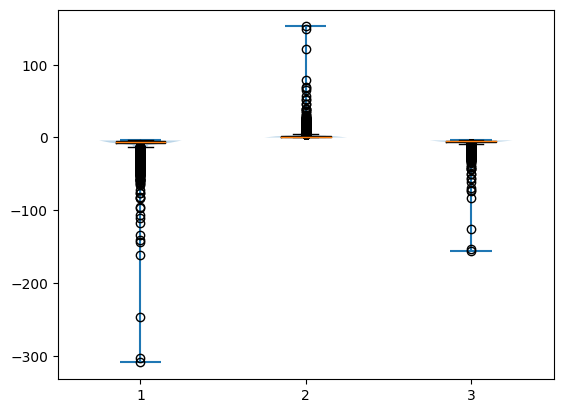

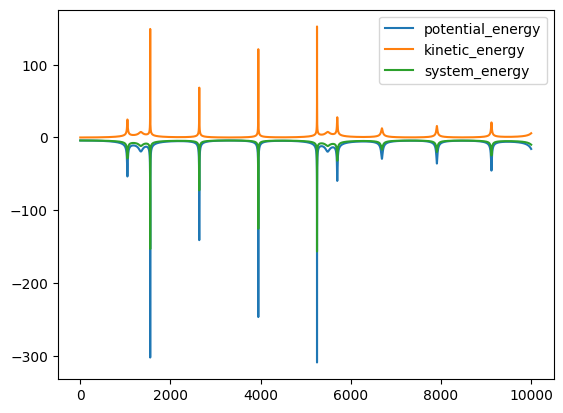

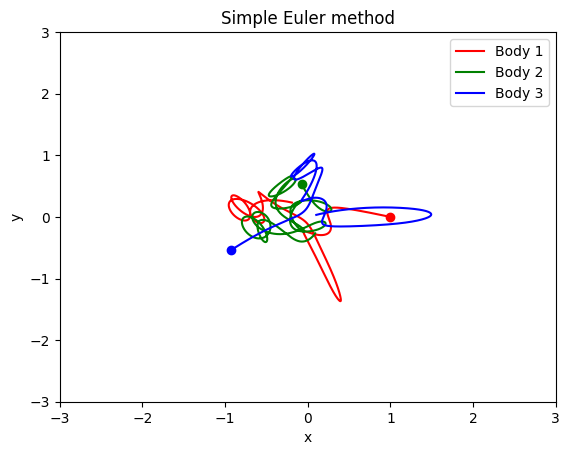

In [5]:
# for dataset, x, y, vx, vy in tbp_util.load_datasets(load_successful=False, load_unsuccessful=True, limit=1):
#     visualize_dataset(x, y, vx, vy)
#
visualize_dataset(*tbp_util.load_dataset("50000"), G, M)

In [5]:
x, y, vx, vy = tbp_util.load_dataset("50000")
x[0, :]

array([ 1.        , -0.07508404, -0.92491596])

In [6]:
y[0, :]

array([ 0.        ,  0.53510511, -0.53510511])

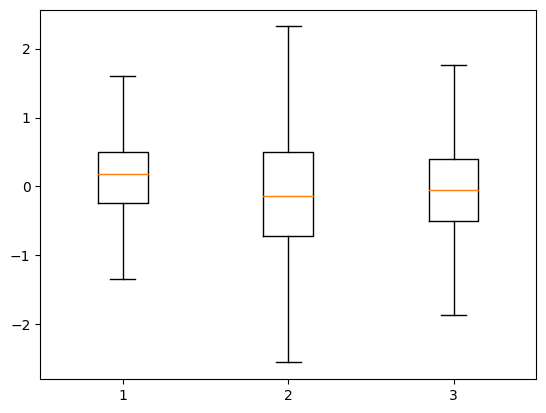

In [52]:
dx = x[:-1] - x[1:,]
dx = dx * 1000000
plt.figure()
plt.boxplot(dx, showfliers=False)
plt.show()

In [6]:
from tensorflow import keras

keras.backend.set_floatx('float64')
keras.backend.floatx()

'float64'

Load training data

In [8]:
x_train = np.ndarray((0, 12), dtype=np.float64)
y_train = np.ndarray((0, 12), dtype=np.float64)

for dataset, x, y, vx, vy in tbp_util.load_datasets(limit=100):
    input_data = np.column_stack((x, y, vx, vy))
    output_data = input_data.copy()

    # predict 1000 samples into the future and delete 9/10 training examples to speed-up training
    input_data = input_data[:-1000:10, ]
    output_data = output_data[1000::10, ]

    x_train = np.concatenate((x_train, input_data))
    y_train = np.concatenate((y_train, output_data))


first training example **[ x1, x2, x3, y1, y2, y3, vx1, vx2, vx3, vy1, vy2, vy3 ]**
first testing  example **[ x1', x2', x3', y1', y2', y3', vx1', vx2', vx3', vy1', vy2', vy3' ]**

In [9]:
x_train[0,]

array([ 1.        , -0.06919072, -0.93080928,  0.        ,  0.80646827,
       -0.80646827,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [10]:
y_train[0,]

array([ 9.99999672e-01, -6.91905684e-02, -9.30809104e-01,  1.23860948e-07,
        8.06467969e-01, -8.06468093e-01, -6.55872758e-04,  3.04219860e-04,
        3.51652898e-04,  2.47721937e-04, -5.99519415e-04,  3.51797478e-04])

array([-6.59152155e+00,  3.05740964e+00,  3.53411200e+00,  2.48960547e+00,
       -6.02517036e+00,  3.53556429e+00, -6.55873115e+03,  3.04220091e+03,
        3.51653025e+03,  2.47722105e+03, -5.99519694e+03,  3.51797589e+03])

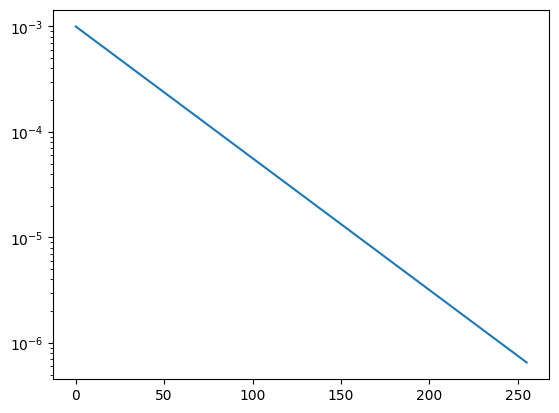

In [10]:
batch_size = 256
epochs = 256
validation_split = 0.1
steps_per_epoch = round((x_train.shape[0] * (1 - validation_split)) / batch_size)

# try to keep it above 10^-8
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_rate=0.75,
    decay_steps=steps_per_epoch * 10
)
plt.figure()
plt.yscale('log')
plt.plot([learning_rate_schedule(epoch * steps_per_epoch) for epoch in range(epochs)])
plt.show()

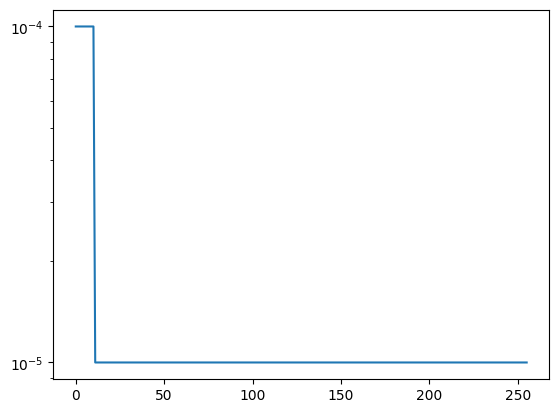

In [11]:
batch_size = 256
epochs = 256
validation_split = 0.1
steps_per_epoch = round((x_train.shape[0] * (1 - validation_split)) / batch_size)

boundaries = np.array([10]) * steps_per_epoch

values = [0.0001, 0.00001]
learning_rate_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries.tolist(), values)
plt.figure()
plt.yscale('log')
plt.plot([learning_rate_schedule(epoch * steps_per_epoch) for epoch in range(epochs)])
plt.show()

In [7]:
model = keras.Sequential([
    keras.layers.Dense(64, activation=keras.activations.relu, input_shape=[12]),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(12, activation=keras.activations.linear)
])

model.compile(
    # keras.optimizers.Adam(learning_rate=learning_rate_schedule),
    keras.optimizers.Adam(learning_rate=0.000001),
    loss='mae',
    metrics=['mae', 'mse']
)

In [31]:
hist_callback = keras.callbacks.History()
callbacks = [
    hist_callback
]

In [32]:
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=callbacks
)

Epoch 1/256
56245/56245 [==============================] - 189s 3ms/step - loss: 0.2899 - mae: 0.2899 - mse: 0.2410 - val_loss: 0.1349 - val_mae: 0.1349 - val_mse: 0.0517
Epoch 2/256
56245/56245 [==============================] - 195s 3ms/step - loss: 0.0685 - mae: 0.0685 - mse: 0.0294 - val_loss: 0.0803 - val_mae: 0.0803 - val_mse: 0.0286
Epoch 3/256
56245/56245 [==============================] - 191s 3ms/step - loss: 0.0367 - mae: 0.0367 - mse: 0.0194 - val_loss: 0.0555 - val_mae: 0.0555 - val_mse: 0.0204
Epoch 4/256
56245/56245 [==============================] - 192s 3ms/step - loss: 0.0271 - mae: 0.0271 - mse: 0.0180 - val_loss: 0.0490 - val_mae: 0.0490 - val_mse: 0.0191
Epoch 5/256
56245/56245 [==============================] - 190s 3ms/step - loss: 0.0229 - mae: 0.0229 - mse: 0.0176 - val_loss: 0.0459 - val_mae: 0.0459 - val_mse: 0.0187
Epoch 6/256
56245/56245 [==============================] - 187s 3ms/step - loss: 0.0204 - mae: 0.0204 - mse: 0.0174 - val_loss: 0.0439 - val_mae:

In [38]:
plt.figure()
plt.plot(hist_callback.history['loss'])
plt.show()

In [8]:
dataset_to_predict = '20006'
x, y, vx, vy = tbp_util.load_dataset(dataset_to_predict)
print(x.shape)

(10000000, 3)


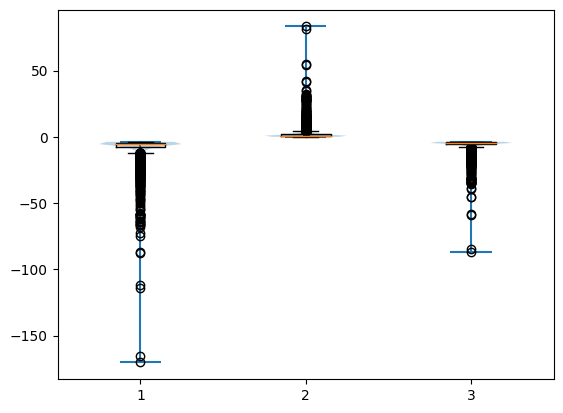

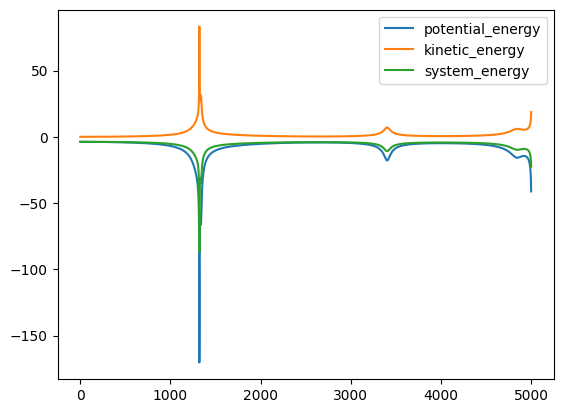

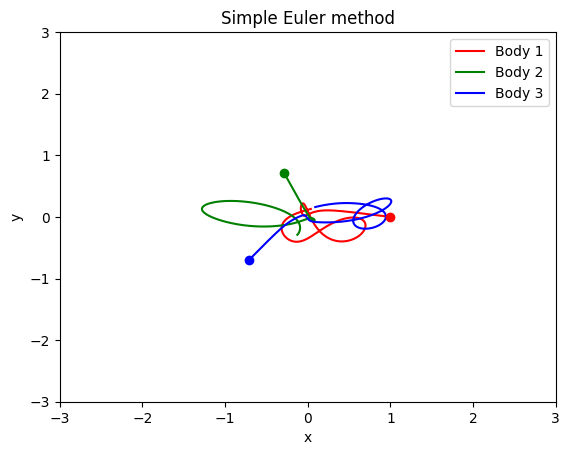

In [9]:
length_to_predict = 5000000
x = x[0:length_to_predict, ]
y = y[0:length_to_predict, ]
vx = vx[0:length_to_predict, ]
vy = vy[0:length_to_predict, ]
visualize_dataset(x, y, vx, vy, 1000)

In [17]:

limit = round(length_to_predict / 1000)
limit = 1000
y_pred = np.zeros((limit, 12), dtype=np.float64)
y_pred[0,] = np.concatenate((x[0,], y[0,], vx[0,], vy[0,]))

for i in range(limit - 1):
    prediction = model(y_pred[i,].reshape(1, 12), training=False).numpy()
    y_pred[i + 1,] = prediction

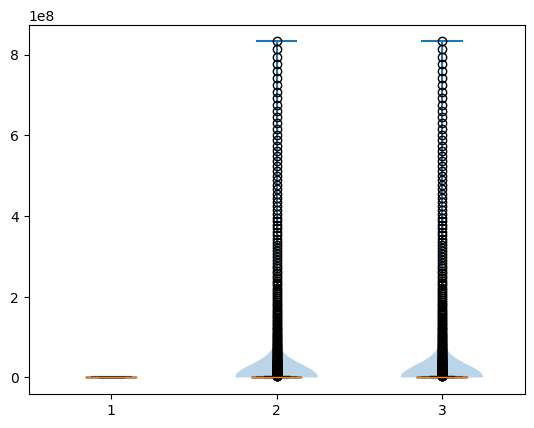

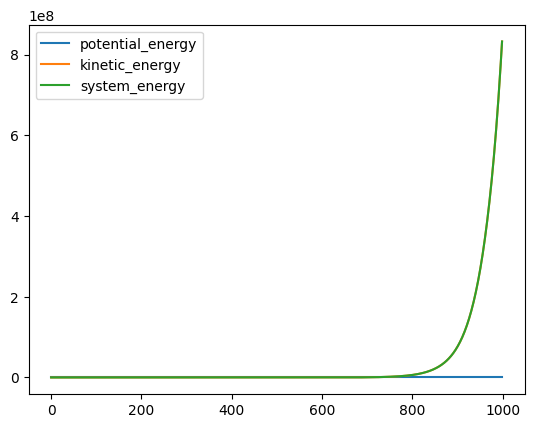

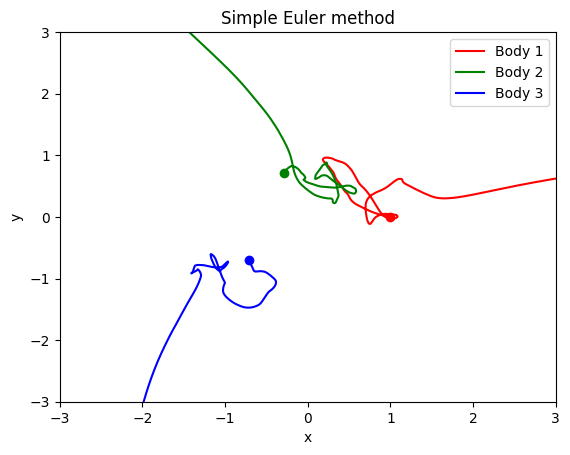

In [18]:
x, y, vx, vy = np.hsplit(y_pred, 4)
# x, y, vx, vy = np.hsplit(x_train[:25000], 4)
visualize_dataset(x, y, vx, vy, down_sample_factor=1)

In [ ]:
visualize_dataset(*tbp_util.load_dataset('2'))

In [39]:
model.save()

In [40]:
for x in ["h5", "keras", "tf"]:
    model.save(f"model.{x}", save_format=x)

In [41]:
for x in ["h5", "tf"]:
    model.save_weights(f"model_weights.{x}", save_format=x)

In [14]:
model.load_weights("model_weights.h5")